In [1]:
import pandas as pd
import os, sklearn
import numpy as np

In [2]:
np.random.seed(0)

In [3]:
X = []
y = []
look_back = 500
max_sample = 200
dataset_folder = "./itelma_dataset"
for diagnosis in ["hypoxia", "regular"]:
    for fc, folder in enumerate(sorted(os.listdir(os.path.join(dataset_folder, diagnosis)))):
        print(f"folder {fc} out of {len(os.listdir(os.path.join(dataset_folder, diagnosis)))}")
        for file in sorted(os.listdir(os.path.join(dataset_folder, diagnosis, folder, "bpm"))):
            df = None
            bpm_file_name = os.path.join(dataset_folder, diagnosis, folder, "bpm", file)
            uterus_file_name = bpm_file_name.replace("1.csv", "2.csv").replace("3.csv", "4.csv").replace("bpm", "uterus")
            bpm_df = pd.read_csv(bpm_file_name)
            bpm_df.rename({"value": "bpm"}, axis=1, inplace=True)
            try:
                uterus_df = pd.read_csv(uterus_file_name)
                uterus_df.rename({"value": "uterus"}, axis=1, inplace=True)
                df = bpm_df.merge(uterus_df, on="time_sec", how="inner")
                #df = bpm_df.merge(uterus_file_name, on="time_sec", how="outer")
                '''df["time_sec"] = df["time_sec"].apply(lambda x: int(round(x / 0.127029))).astype('int')
                df["group_id"] = i
                i += 1
                fin.append(df)'''
                idx_list = range(len(df) - 1 - look_back)
                if len(idx_list) > max_sample:
                    idx_list = np.random.choice(idx_list, max_sample, replace=False)
                for idx in idx_list:
                    X.append(df[["bpm", "uterus"]].iloc[idx:idx+look_back].to_numpy())
                    y.append(diagnosis == "regular")
                    #y.append((lambda x: [x, 1 - x])(int(diagnosis == "regular")))
                #X.extend(np.random.choice(_X, min(max_sample, len(_X))))
                #y.extend(np.random.choice(_y, min(max_sample, len(_y))))
            except:
                pass
    print()

folder 0 out of 29
folder 1 out of 29
folder 2 out of 29
folder 3 out of 29
folder 4 out of 29
folder 5 out of 29
folder 6 out of 29
folder 7 out of 29
folder 8 out of 29
folder 9 out of 29
folder 10 out of 29
folder 11 out of 29
folder 12 out of 29
folder 13 out of 29
folder 14 out of 29
folder 15 out of 29
folder 16 out of 29
folder 17 out of 29
folder 18 out of 29
folder 19 out of 29
folder 20 out of 29
folder 21 out of 29
folder 22 out of 29
folder 23 out of 29
folder 24 out of 29
folder 25 out of 29
folder 26 out of 29
folder 27 out of 29
folder 28 out of 29

folder 0 out of 98
folder 1 out of 98
folder 2 out of 98
folder 3 out of 98
folder 4 out of 98
folder 5 out of 98
folder 6 out of 98
folder 7 out of 98
folder 8 out of 98
folder 9 out of 98
folder 10 out of 98
folder 11 out of 98
folder 12 out of 98
folder 13 out of 98
folder 14 out of 98
folder 15 out of 98
folder 16 out of 98
folder 17 out of 98
folder 18 out of 98
folder 19 out of 98
folder 20 out of 98
folder 21 out of 98

In [4]:
y = np.array(y)
y.shape

(232934,)

In [5]:
X = np.array(X).transpose((0, 2, 1))
X.shape

(232934, 2, 500)

In [7]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((186347, 2, 500), (46587, 2, 500), (186347,), (46587,))

In [15]:
from tsai.all import *

In [16]:
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

In [17]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

In [18]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()])

In [23]:
model = ResCNN(dls.vars, dls.c)
learn = Learner(dls, model, metrics=[accuracy])

SuggestedLRs(valley=0.0030199517495930195)

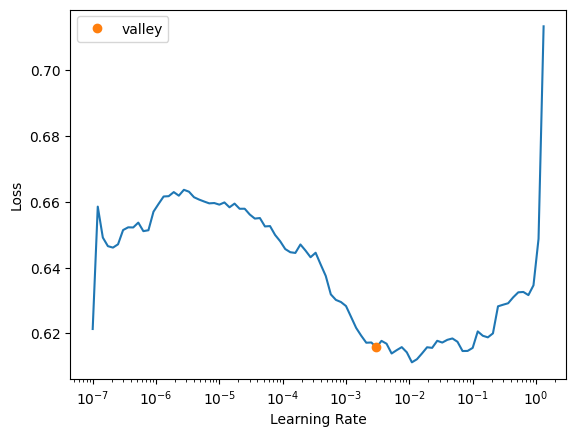

In [24]:
learn.lr_find()

In [25]:
learn.fit_one_cycle(25, lr_max=1.1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.503541,0.510952,0.759289,00:34
1,0.482365,0.457501,0.792710,00:33
2,0.448989,0.488131,0.777685,00:33
3,0.409636,0.401354,0.822053,00:33
4,0.382103,0.999083,0.789104,00:34
5,0.293697,1.542578,0.756198,00:33
6,0.252164,0.343153,0.863288,00:34
7,0.202671,0.410357,0.850602,00:33
8,0.158382,0.892878,0.681950,00:34
9,0.146371,0.444580,0.875931,00:34


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [33]:
preds = learn.get_X_preds(X_test)[0]
preds.shape, y_test.shape

(torch.Size([46587, 2]), (46587,))

In [40]:
preds = preds.argmax(axis=1)
preds

tensor([1, 0, 1,  ..., 1, 1, 0])

In [41]:
y_test = y_test.astype('int')
y_test

array([1, 0, 1, ..., 1, 1, 0], shape=(46587,))

In [42]:
accuracy_score(y_test, preds), precision_score(y_test, preds), recall_score(y_test, preds), f1_score(y_test, preds), roc_auc_score(y_test, preds)

(0.9996780217657286,
 0.9995586659100939,
 0.9999684632123372,
 0.9997635225678296,
 0.9995137382602888)

In [43]:
preds = learn.get_X_preds(X_train)[0]
preds = preds.argmax(axis=1)
y_train = y_train.astype('int')
accuracy_score(y_train, preds), precision_score(y_train, preds), recall_score(y_train, preds), f1_score(y_train, preds), roc_auc_score(y_train, preds)

(0.9999624356710868,
 0.9999684888017079,
 0.9999763664151002,
 0.9999724275928895,
 0.9999545182746274)

In [44]:
learn.export("res_cnn.pt")